# Counting Objects: Part II

After [sharing my work](https://forums.fast.ai/t/share-your-work-here/27676/805) on the fastai forums, I received a number suggestions and requests for futher investigation.

The most common were:
 - Some transforms seemed uneccessary (eg. crop and zoom)
 - Some transforms might be more useful (eg. vertical flip)
 - Consider training the model from scratch (inputs come from a different distribution)
 - Try with more data
 - Try with different sizes


### How accurate can we get?

Let's start by applying sensible transforms, training the entire network and using more data to see if we can drive the accuracy higher. 

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate

import random
import numpy as np
import matplotlib.pyplot as plt

Once again we'll create non-overlapping circles.

In [74]:
def createNonOverlappingPoints(numElements):
    x = np.zeros((numElements)) + 2  #Place the cirlces offscreen
    y = np.zeros((numElements)) + 2  #Place the circles offscreen
    
    for i in range(0, numElements):
        
        foundNewCircle = False
        
        #Loop until we find a non-overlapping position for our new circle
        while not foundNewCircle:
            randX = random.uniform(-1, 1)
            randY = random.uniform(-1, 1)

            distanceFromOtherCircles = np.sqrt(np.square(x - randX) + np.square(y - randY))

            # Ensure that this circle is far enough away from all others
            if np.all(distanceFromOtherCircles > 0.2):
                break

        x[i] = randX
        y[i] = randY

    return x, y

This time we'll generate 5,000 images per class (as opposed to 1,000) each with 45-49 circles in it.

In [46]:
import os
from tqdm import tnrange


def generateImages(numberOfPoints):
    directory = 'data/counting/' + str(numberOfPoints) + '/'
    os.makedirs(directory, exist_ok=True)
    
    #Create 5,000 images of this class
    for j in tnrange(5000):
        path = directory + str(j) + '.png'
        #Get points
        x, y = createNonOverlappingPoints(numberOfPoints)
        #Create plot
        plt.clf()
        axes = plt.gca()
        axes.set_xlim([-2,2])
        axes.set_ylim([-2, 2])
        plt.scatter(x,y, s=200)
        plt.axes().set_aspect('equal', 'datalim')
        #Save to disk
        plt.savefig(path)        

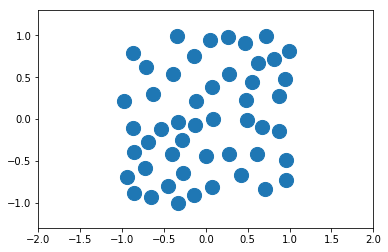

In [49]:
generateImages(45)
generateImages(46)
generateImages(47)
generateImages(48)
generateImages(49)

(**Sidenote**: If anyone knows why image generation slows down so much, please let me know!)

This time we'll only allow for horizontal and vertical flip transformations.

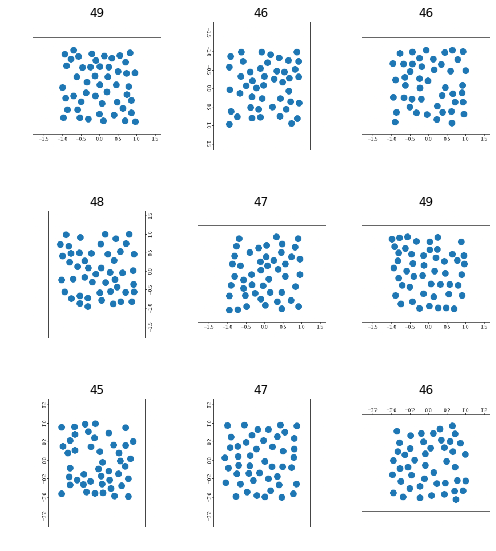

In [101]:
path = 'data/counting'

np.random.seed(42)

# Only transform is flipping


transforms = get_transforms(flip_vert=True, 
                            max_zoom=0, 
                            max_rotate=0, 
                            max_lighting=0, 
                            max_warp=0,
                            p_affine=0,
                            p_lighting=0)

#Hack, I don't know how to remove crop and pad
flip_transform = transforms[0][1]
only_flip_transforms = [[flip_transform],[]]

data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=only_flip_transforms, size=224, num_workers=4).normalize(imagenet_stats)

data.show_batch(rows=3, figsize=(7,8))

Let's create a learner and unfreeze it so we're training the whole network.

In [70]:
learner = create_cnn(data, models.resnet34, metrics=error_rate)
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


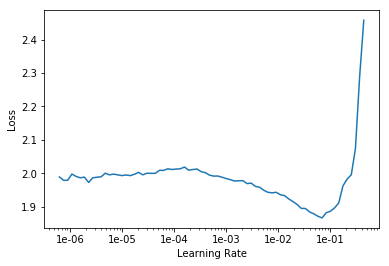

In [71]:
learner.lr_find()
learner.recorder.plot()

It looks like the best learning rates occur at some point between `1e-4` and `1e-2` so we'll give those a shot.

In [73]:
learner.fit_one_cycle(15, max_lr=slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.881368,1.027981,0.425400
2,0.522674,3.760669,0.758600
3,0.383927,24.037830,0.802200
4,0.256538,21.700485,0.802200
5,0.191156,0.705828,0.262400
6,0.107883,9.944717,0.805000
7,0.100229,21.140575,0.808800
8,0.070060,1.655320,0.461000
9,0.031124,5.713477,0.782200
10,0.019522,0.017430,0.004600


Wow! Look at that, this time we're getting 100% accuracy. It looks like if we throw enough data at it (and use proper transforms) this is a problem that can actually be trivially solved by convolutional neural networks. I honestly did not expect that at all going into this.

### Circles of various sizes

One drawback of our previous dataset is that the objects we're counting are all the same size. Is it possible this is making the task too easy? Let's try creating a dataset with circles of various sizes.

In [91]:
def generateImagesOfVariousSizes(numberOfPoints):
    directory = 'data/countingVariousSizes/' + str(numberOfPoints) + '/'
    os.makedirs(directory, exist_ok=True)
    
    #Create 5,000 images of this class
    for j in tnrange(5000):
        path = directory + str(j) + '.png'
        #Get points
        x, y = createNonOverlappingPoints(numberOfPoints)
        #Create plot
        plt.clf()
        axes = plt.gca()
        axes.set_xlim([-2,2])
        axes.set_ylim([-2, 2])
        
        #This time we'll generate a random size for each marker
        sizes = [random.uniform(25, 250) for _ in range(len(x))]
        plt.scatter(x,y, s=sizes)
        plt.axes().set_aspect('equal', 'datalim')
        #Save to disk
        plt.savefig(path)    

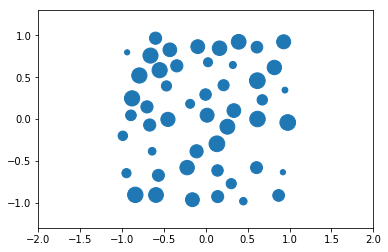

In [92]:
generateImagesOfVariousSizes(45)
generateImagesOfVariousSizes(46)
generateImagesOfVariousSizes(47)
generateImagesOfVariousSizes(48)
generateImagesOfVariousSizes(49)

Now we'll build an `ImageDataBunch` and take a look at the dataset.

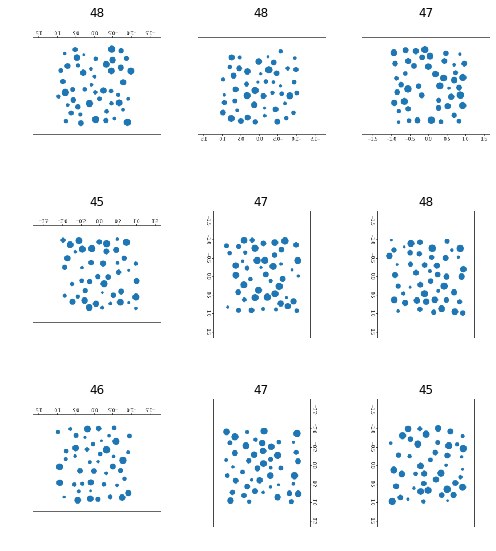

In [97]:
path = 'data/countingVariousSizes'

np.random.seed(42)

# Only transform is flipping
transforms = get_transforms(flip_vert=True, 
                            max_zoom=0, 
                            max_rotate=0, 
                            max_lighting=0, 
                            max_warp=0,
                            p_affine=0,
                            p_lighting=0)

#Hack, I don't know how to remove crop and pad
flip_transform = transforms[0][1]
only_flip_transforms = [[flip_transform],[]]

data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=only_flip_transforms, size=224, num_workers=4).normalize(imagenet_stats)

data.show_batch(rows=3, figsize=(7,8))

In [98]:
learner = create_cnn(data, models.resnet34, metrics=error_rate)
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


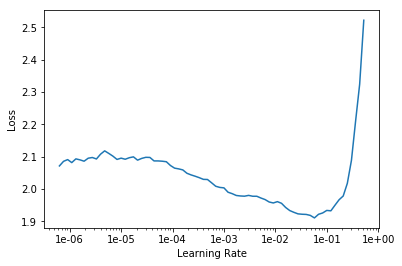

In [99]:
learner.lr_find()
learner.recorder.plot()

Once again it looks like `1e-4` and `1e2` are good bounds for our learning rate.

In [100]:
learner.fit_one_cycle(15, max_lr=slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,error_rate
1,1.075099,0.807987,0.381000
2,0.613711,5.742334,0.796600
3,0.384476,0.604430,0.294800
4,0.331689,5.039052,0.802000
5,0.212419,12.546182,0.802200
6,0.127342,11.482450,0.806200
7,0.064278,0.567820,0.247800
8,0.086790,7.240054,0.802000
9,0.092476,274.882324,0.802200
10,0.080682,4.221457,0.760000


Still works! Once again I'm surprised. I had very little hope for this problem but these networks seem to have absolutely no issue with solving this.